<a href="https://colab.research.google.com/github/Abdullah-Al-Roman/research-paper/blob/main/banglabert_toxicity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/119 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/586 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/528k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/443M [00:00<?, ?B/s]

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at csebuetnlp/banglabert and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting training...

Epoch 1/16:
Average Training Loss: 1.3469
Average Validation Loss: 1.0451
Validation Accuracy: 0.6380
Validation F1 Score: 0.6269

New best model saved with validation loss: 1.0451
Epoch 2/16:
Average Training Loss: 0.8992
Average Validation Loss: 0.9754
Validation Accuracy: 0.6727
Validation F1 Score: 0.6711

New best model saved with validation loss: 0.9754
Epoch 3/16:
Average Training Loss: 0.6785
Average Validation Loss: 1.0157
Validation Accuracy: 0.6740
Validation F1 Score: 0.6736

Epoch 4/16:
Average Training Loss: 0.4801
Average Validation Loss: 1.1619
Validation Accuracy: 0.6700
Validation F1 Score: 0.6690

Epoch 5/16:
Average Training Loss: 0.3299
Average Validation Loss: 1.2669
Validation Accuracy: 0.6447
Validation F1 Score: 0.6446

Epoch 6/16:
Average Training Loss: 0.2242
Average Validation Loss: 1.4015
Validation Accuracy: 0.6600
Validation F1 Score: 0.6581

Epoch 7/16:
Average Training Loss: 0.1662
Average Validation Loss: 1.4782
Validation Accurac

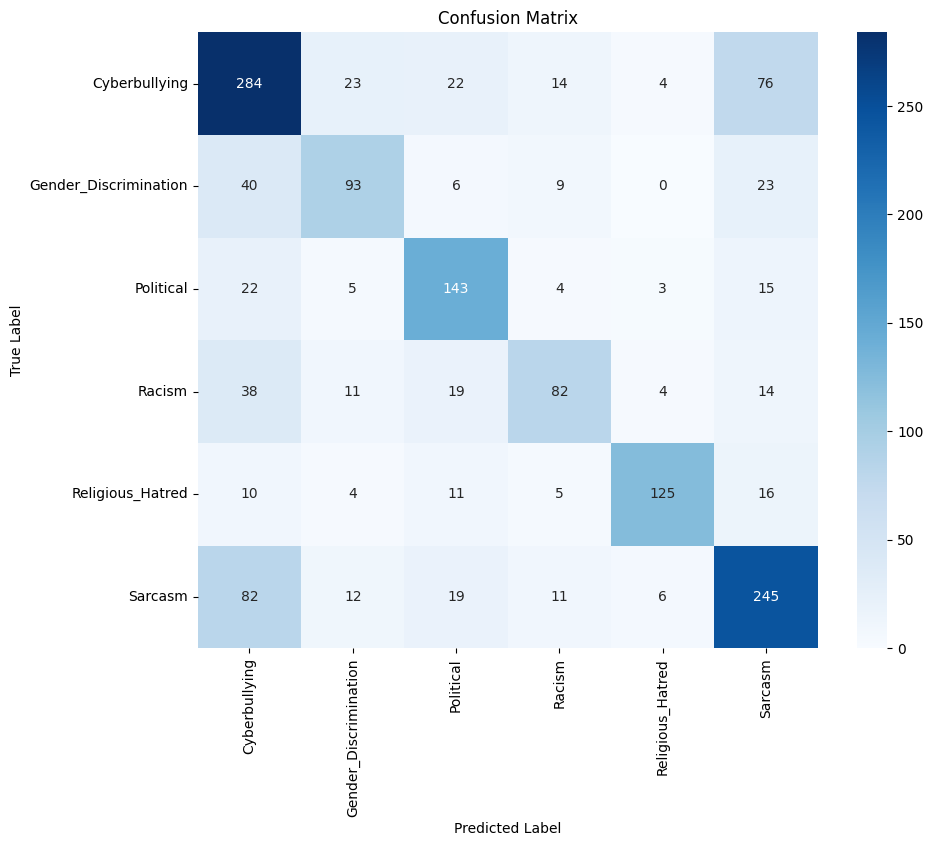

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset
import seaborn as sns
import matplotlib.pyplot as plt

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Load the dataset
df = pd.read_csv('/content/merged (1).csv')

# Encode labels
label_encoder = LabelEncoder()
df['labels'] = label_encoder.fit_transform(df['labels'])

# First split data into train and temp
X_train, X_temp, y_train, y_temp = train_test_split(df['text'],
                                                   df['labels'],
                                                   test_size=0.3,
                                                   random_state=42,
                                                   stratify=df['labels'])

# Split temp into val and test
X_val, X_test, y_val, y_test = train_test_split(X_temp,
                                               y_temp,
                                               test_size=0.5,
                                               random_state=42,
                                               stratify=y_temp)

# Initialize tokenizer and model
# Load model directly
from transformers import AutoTokenizer, AutoModelForPreTraining

tokenizer = AutoTokenizer.from_pretrained("csebuetnlp/banglabert")
model = AutoModelForPreTraining.from_pretrained("csebuetnlp/banglabert")
num_labels = len(label_encoder.classes_)
model_name = "csebuetnlp/banglabert"
model = AutoModelForSequenceClassification.from_pretrained(model_name,
                                                         num_labels=num_labels)

# Tokenize the texts
max_length = 128

def tokenize_data(texts):
    return tokenizer(texts.tolist(),
                    padding=True,
                    truncation=True,
                    max_length=max_length,
                    return_tensors='pt')

# Tokenize all splits
train_encodings = tokenize_data(X_train)
val_encodings = tokenize_data(X_val)
test_encodings = tokenize_data(X_test)

# Convert labels to tensors
train_labels = torch.tensor(y_train.values)
val_labels = torch.tensor(y_val.values)
test_labels = torch.tensor(y_test.values)

# Create datasets
train_dataset = TensorDataset(
    train_encodings['input_ids'],
    train_encodings['attention_mask'],
    train_labels
)

val_dataset = TensorDataset(
    val_encodings['input_ids'],
    val_encodings['attention_mask'],
    val_labels
)

test_dataset = TensorDataset(
    test_encodings['input_ids'],
    test_encodings['attention_mask'],
    test_labels
)

# Create dataloaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Training settings
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
num_epochs = 16
best_val_loss = float('inf')
best_model_state = None

# Training loop with validation
print("Starting training...\n")

for epoch in range(num_epochs):
    # Training
    model.train()
    total_train_loss = 0

    for batch in train_loader:
        input_ids, attention_mask, labels = [b.to(device) for b in batch]

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_train_loss += loss.item()

        loss.backward()
        optimizer.step()

    avg_train_loss = total_train_loss / len(train_loader)

    # Validation
    model.eval()
    total_val_loss = 0
    val_preds = []
    val_labels_list = []

    with torch.no_grad():
        for batch in val_loader:
            input_ids, attention_mask, labels = [b.to(device) for b in batch]
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            total_val_loss += outputs.loss.item()
            preds = torch.argmax(outputs.logits, dim=1)

            val_preds.extend(preds.cpu().numpy())
            val_labels_list.extend(labels.cpu().numpy())

    avg_val_loss = total_val_loss / len(val_loader)
    val_accuracy = accuracy_score(val_labels_list, val_preds)
    val_f1 = f1_score(val_labels_list, val_preds, average='weighted')

    print(f'Epoch {epoch + 1}/{num_epochs}:')
    print(f'Average Training Loss: {avg_train_loss:.4f}')
    print(f'Average Validation Loss: {avg_val_loss:.4f}')
    print(f'Validation Accuracy: {val_accuracy:.4f}')
    print(f'Validation F1 Score: {val_f1:.4f}\n')

    # Save best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model_state = model.state_dict().copy()
        print(f"New best model saved with validation loss: {avg_val_loss:.4f}")

# Load best model for testing
print("Loading best model for testing...")
model.load_state_dict(best_model_state)

# Final evaluation on test set
model.eval()
test_preds = []
test_labels_list = []

with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, labels = [b.to(device) for b in batch]
        outputs = model(input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1)

        test_preds.extend(preds.cpu().numpy())
        test_labels_list.extend(labels.cpu().numpy())

# Calculate all metrics
test_accuracy = accuracy_score(test_labels_list, test_preds)
test_precision = precision_score(test_labels_list, test_preds, average='weighted')
test_recall = recall_score(test_labels_list, test_preds, average='weighted')
test_f1 = f1_score(test_labels_list, test_preds, average='weighted')
conf_matrix = confusion_matrix(test_labels_list, test_preds)
class_report = classification_report(test_labels_list, test_preds,
                                   target_names=label_encoder.classes_)

# Print results
print("\nFinal Test Results:")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1 Score: {test_f1:.4f}")

print("\nClassification Report:")
print(class_report)

# Plot confusion matrix with Bengali labels
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix,
            annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig('BanglaBERT.png')
plt.show()

# Save results
with open('bangla_bert_classification_results.txt', 'w', encoding='utf-8') as f:
    f.write("Bangla-BERT Classification Results\n")
    f.write("================================\n\n")
    f.write(f"Model: {model_name}\n\n")
    f.write(f"Test Accuracy: {test_accuracy:.4f}\n")
    f.write(f"Test Precision: {test_precision:.4f}\n")
    f.write(f"Test Recall: {test_recall:.4f}\n")
    f.write(f"Test F1 Score: {test_f1:.4f}\n\n")
    f.write("Classification Report:\n")
    f.write(class_report)